# Training loop

Let us train a simple feed-forward dataset on modular addition.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

Let us load the dataset and a simple model that can [analytically solve the task at hand](https://arxiv.org/abs/2310.13061).

In [3]:
from mathllm.model.mlp import MLP, MLPConfig
from mathllm.config import DATA_DIR

problem = 'single_base'
save_dir = DATA_DIR / problem
z = 60

x_train = torch.load(save_dir / 'x_train.pt')
y_train = torch.load(save_dir / 'y_train.pt').to(torch.long)
x_test = torch.load(save_dir / 'x_test.pt')
y_test = torch.load(save_dir / 'y_test.pt').to(torch.long)

def get_input_repr(x):
    n = x.size(0)
    out = torch.zeros((n, 2*z))
    out[torch.arange(n), x[:, 0]] = 1
    out[torch.arange(n), x[:, 1] + 60] = 1
    return out

in_train = get_input_repr(x_train)
in_test  = get_input_repr(x_test )

config = MLPConfig(
    fan_in=2*z,
    hidden_dim=z,
    fan_out=z,
    activation='square',
    residual=False,
    dropout=.3,
)

## Optimizer

Autograd allows to implement gradient descent easily.

In [4]:
torch.manual_seed(0)
model = MLP(config)
learning_rate = 1e1
losses = []
test_losses = []

n_epochs = 1000
for _ in range(n_epochs):
    model.train()
    model.zero_grad()
    logit = model(in_train)
    loss = F.cross_entropy(logit, y_train)
    loss.backward()
    with torch.no_grad():
        model.eval()
        for p in model.parameters():
            p -= learning_rate * p.grad
        losses.append(loss.item())

        pred = model(in_test).argmax(dim=1)
        test_losses.append((pred != y_test).float().mean().item())

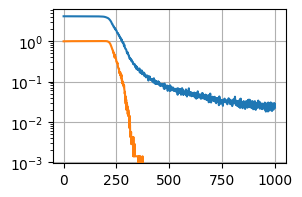

In [5]:
plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.plot(test_losses)
plt.yscale('log')
plt.grid()

We can define the optimizer as an object, as well as monitor it with a scheduler object.

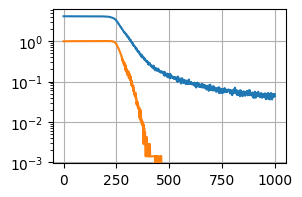

In [6]:
class GradientDescent:
    def __init__(self, model, lr=1):
        self.param_call = model.parameters
        self.lr = lr

    def step(self, closure=None):
        with torch.no_grad():
            for p in self.param_call():
                p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.param_call():
            p.grad = None

class Scheduler:
    def __init__(self, optimizer, decay=.001):
        self.optimizer = optimizer
        self.factor = 1 - decay

    def step(self):
        self.optimizer.lr *= self.factor

torch.manual_seed(0)
model = MLP(config)
optimizer = GradientDescent(model, lr=1e1)
scheduler = Scheduler(optimizer, decay=0.001)

losses = []
test_losses = []

n_epochs = 1000
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logit = model(in_train)
    loss = F.cross_entropy(logit, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    with torch.no_grad():
        model.eval()
        losses.append(loss.item())
        pred = model(in_test).argmax(dim=1)
        test_losses.append((pred != y_test).float().mean().item())

plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.plot(test_losses)
plt.yscale('log')
plt.grid()

Pytorch does implement optimizers and schedulers for us.
Let us cast our optimizer within PyTorch API.

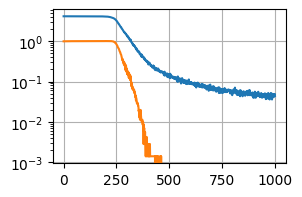

In [7]:
import torch.optim as optim

class GradientDescent(optim.Optimizer):
    def __init__(self, params, lr=1):
        super().__init__(params, dict(lr=lr))

    def step(self, closure=None):
        with torch.no_grad():
            for group in self.param_groups:
                params = group['params']
                lr = group['lr']
                for p in params:
                    p -= lr * p.grad

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                p.grad = None

class Scheduler(optim.lr_scheduler.LRScheduler):
    def __init__(self, optimizer, decay=.001):
        self.factor = 1 - decay
        super().__init__(optimizer, -1, False)

    def get_lr(self):
        groups = [group['lr'] * self.factor for group in self.optimizer.param_groups]
        return groups

torch.manual_seed(0)
model = MLP(config)
optimizer = GradientDescent(model.parameters(), lr=1e1)
scheduler = Scheduler(optimizer, decay=0.001)

losses = []
test_losses = []

n_epochs = 1000
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logit = model(in_train)
    loss = F.cross_entropy(logit, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    with torch.no_grad():
        model.eval()
        losses.append(loss.item())
        pred = model(in_test).argmax(dim=1)
        test_losses.append((pred != y_test).float().mean().item())

plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.plot(test_losses)
plt.yscale('log')
plt.grid()

Many optimizers and scheduler are natively supported by Pytorch.

<function matplotlib.pyplot.savefig(*args, **kwargs) -> 'None'>

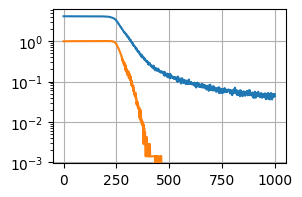

In [8]:
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR

torch.manual_seed(0)
model = MLP(config)
optimizer = SGD(model.parameters(), lr=1e1)
scheduler = ExponentialLR(optimizer, gamma=1-0.001)

losses = []
test_losses = []

n_epochs = 1000
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logit = model(in_train)
    loss = F.cross_entropy(logit, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    with torch.no_grad():
        model.eval()
        losses.append(loss.item())
        pred = model(in_test).argmax(dim=1)
        test_losses.append((pred != y_test).float().mean().item())

plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.plot(test_losses)
plt.yscale('log')
plt.grid()

## Pipeline

The training loop is the main part of the training process.
Usual pipelines include two additions:
- Dataloader: which defines an abstract method to iterate over the dataset.
- Checkpointing: in order to avoid loosing progress when encountering a bug, it is usual to save the model (and eventually the optimizer, scheduler and data loader states) from time to time.

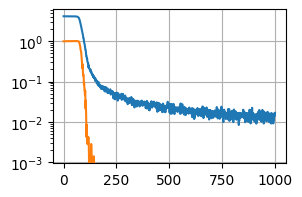

In [9]:
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0)
torch.cuda.manual_seed(0)

batch_size = 1024

trainset = TensorDataset(in_train, y_train)
loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(in_test, y_test)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

device = 'cuda'
save_period = 2

torch.manual_seed(0)
model = MLP(config).to(device)
optimizer = SGD(model.parameters(), lr=1e1)
scheduler = ExponentialLR(optimizer, gamma=1-0.001)

losses = []
test_losses = []

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    running_loss = i = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()
        running_loss *= i / (i + len(x))
        running_loss += loss.item() * (len(x) / (i + len(x)))
        i += len(x)
    scheduler.step()
    losses.append(running_loss)

    with torch.no_grad():
        model.eval()
        test_loss = i = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            test_loss *= i / (i + len(x))
            test_loss += (pred != y).float().mean().item() * (len(x) / (i + len(x)))
            i += len(x)
        test_losses.append(test_loss)

    if epoch and not epoch % save_period:
        torch.save(model.state_dict(), f'checkpoint.pth')

plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.plot(test_losses)
plt.yscale('log')
plt.grid()

## Data-Distributed Training

When training with many data, it is useful to process batch in parallel before gathering the different gradients to update the model.
This is implemented by PyTorch with the `DDP` module.

Let us dive in on my machine with 2 GPUs.
We can not use the `DDP` module inside a notebook, so we will outsource the code and launch it as a python script.

I recommand watching [PyTorch DDP tutorials on YouTube](https://www.youtube.com/watch?v=-K3bZYHYHEA).

In [10]:
%run 'support/train_ddp.py'

GPU0 | Epoch 2 | Loss 4.094 | Test Loss 0.989
GPU0 | Epoch 4 | Loss 4.094 | Test Loss 0.989
GPU0 | Epoch 6 | Loss 4.094 | Test Loss 0.989
GPU0 | Epoch 8 | Loss 4.094 | Test Loss 0.989
GPU0 | Epoch 10 | Loss 4.094 | Test Loss 0.989
GPU0 | Epoch 12 | Loss 4.093 | Test Loss 0.991
GPU0 | Epoch 14 | Loss 4.093 | Test Loss 0.991
GPU0 | Epoch 16 | Loss 4.093 | Test Loss 0.994
GPU0 | Epoch 18 | Loss 4.093 | Test Loss 0.994
GPU0 | Epoch 20 | Loss 4.093 | Test Loss 0.994
GPU0 | Epoch 22 | Loss 4.093 | Test Loss 0.994
GPU0 | Epoch 24 | Loss 4.092 | Test Loss 0.994
GPU0 | Epoch 26 | Loss 4.092 | Test Loss 0.997
GPU0 | Epoch 28 | Loss 4.092 | Test Loss 0.997
GPU0 | Epoch 30 | Loss 4.092 | Test Loss 0.997
GPU0 | Epoch 32 | Loss 4.091 | Test Loss 0.997
GPU0 | Epoch 34 | Loss 4.091 | Test Loss 0.997
GPU0 | Epoch 36 | Loss 4.091 | Test Loss 1.000
GPU0 | Epoch 38 | Loss 4.091 | Test Loss 1.000
GPU0 | Epoch 40 | Loss 4.090 | Test Loss 1.000
GPU0 | Epoch 42 | Loss 4.090 | Test Loss 1.000
GPU0 | Epoch 44 |

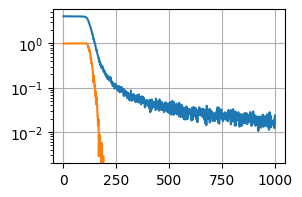

In [12]:
losses = torch.load('losses.pt')
test_losses = torch.load('test_losses.pt')
plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.plot(test_losses)
plt.yscale('log')
plt.grid()

Similarly we can train on several nodes simultaneously.

## Cluster launching

- cluster launcher.
- option to keep always the same data on the same GPU (so to remove all communications between GPU and CPU).
- checkpointing, and requeuing: slurm manual, submitit, hydra, xlformer, ...
- distributed training: torchrun, ...